# Sentiment Analysis: Large Movie Review Dataset

Regarding the data, we are not going to have a __csv file__, that would be too easy :) instead we are going to download the data from [AI Stanford Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). When you download them you will notice that their format is text files, so you will have to work a little there to be able to use and process them. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a movie speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Read data that is not in a traditional format.
* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW or TF-IDF.
* BoW and TF-IDF are classic ways to vectorize text, but currently we have some more complex ways with better performance, for this we are going to train our own word embedding and use it as a vectorization source for our data.
* Train a sentiment analysis model that allows us to detect positive and negative opinions in movie reviews.

In [88]:
# Import classic libraries
import numpy as np
import pandas as pd
import os

# Import modules
from evaluation import plot_roc
import text_normalizer

# Import NLP libraries
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from concurrent.futures import ProcessPoolExecutor
import nltk

# Import Model and metric libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from evaluation import get_performance
from sklearn.metrics import f1_score
from sklearn import metrics
import evaluation
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

---
## 1. Get the data

#### Download the data and process it in order to obtain:

* `X_train:` list with reviews for training.
* `y_train:` list with labels for training.
* `X_test:` list with reviews for testing.
* `y_test:` list with labels for testing.


In [89]:
reviews = []
data_directory = "/home/app/src/aclImdb"
datasets = ["train", "test"]
labels = {'pos': 1, 'neg': 0}

# iterate over datasets directory to generate a list of reviews
for dataset in datasets:
    for label in labels.keys():
        # iterate over classes directory
        labeled_directory = f"{data_directory}/{dataset}/{label}"
        for review in os.listdir(labeled_directory):
            #open each file and save the content in a list of reviews
            with open(f"{labeled_directory}/{review}") as f:
                text = f.read()
                reviews.append({'dataset': dataset,'sentence': text, 'label': labels[label]})

# create a dataframe with the generated reviews list
reviews = pd.DataFrame(reviews)
X_train = reviews[reviews["dataset"] == "train"]
y_train = X_train["label"]

X_test = reviews[reviews["dataset"] == "test"]
y_test = X_test["label"]

### *Don't change anything in this block, just make it run correctly*

We are going to check that you have done it right and for that we are going to see if the dimensions match.

In [90]:
def check_data(X_train, y_train, X_test, y_test):
    if len(X_train) == len(y_train) == len(X_test) == len(y_test) == 25000:
        print('Reading Data Success!')
    else:
        raise ValueError('Dimensions do not match!')

check_data(X_train, y_train, X_test, y_test)

Reading Data Success!


---
## 2. Normalize the data

#### Respect names and minimal interfaces:

* `remove_html_tags(text):` to remove all HTML tags that may be present in text.
* `remove_accented_chars(text):` to remove accented characters from text
* `expand_contractions(text):` to expand contractions of the type, "don't" to "do not". The contractions are already defined in the "contractions.py" file.
* `lemmatize_text(text):` to lemmatize text.
* `stem_text(text):` to apply stemming (NLTK's PorterStemmer) on text.
* `remove_special_chars(text):` to remove special characters from text.
* `remove_special_chars(text, remove_digits=True):` to remove numbers, note that it is the same function to remove special characters with the addition of an argument that enables or disables the removal of numbers.
* `remove_stopwords(text, stopwords=stop_words):` to remove stopwords from text.
* `remove_extra_new_lines(text):` to remove extra newlines from text.
* `remove_extra_whitespace(text):` to remove extra whitespaces from text.

If you want to add more features that would be great, for example you could start by removing emojis, using different stemming algorithms, etc. The more functions you have the better, remember that the texts are very varied and the preprocessing depends a lot on the source of our data.


### *Don't change anything in this block, just make it run correctly*

We are going to check that the pre-processing does what we need it to do, for this we are going to test the functions with predefined inputs and we are going to see if the outputs match what we are looking for.

Note that the functions are not defined in the notebook itself, but rather that they are in a python file and you must import them in order to use them. Same thing with names, you're going to have to name your functions the way they were named.

In [91]:

# Inputs
doc_html = """
<br /><br />But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
doc_accented = "Héllo, thís is an accented sénténce."
doc_contractions = "I can't, because it doesn't work."
doc_lemma = "The striped bats are hanging on their feet for best"
doc_stem = """
Where did he learn to dance like that?
His eyes were dancing with humor.
She shook her head and danced away.
"""
doc_specials = "hello? there A-Z-R_T(,**), world, welcome to python. this **should? the next line#followed- by@ an#other %million^ %%like $this."
doc_digits = "abc123def456ghi789zero0 hello my friend number 10"
doc_stop = "He is a very good person"
doc_new_lines = """we
use
a
lot
of
lines"""
doc_spaces = "Hello           my      dear          friend"

# Outputs
good_html = """
But with plague out there and the news being kept a secret,
the New Orleans PD starts a dragnet of the city's underworld.
"""
good_accented = "Hello, this is an accented sentence."
good_contractions = "I cannot, because it does not work."
good_lemma = "the stripe bat be hang on their foot for good"
good_stem = "where did he learn to danc like that ? hi eye were danc with humor. she shook her head and danc away ."
good_specials = "hello there AZRT world welcome to python this should the next linefollowed by another million like this"
good_digits = "abcdefghizero hello my friend number "
good_stop = "good person"
good_new_lines = "we use a lot of lines"
good_spaces = "Hello my dear friend"
stop_words = nltk.corpus.stopwords.words('english')

def check_normalization():
    if good_html == text_normalizer.remove_html_tags(doc_html):
        print('[1/10] Remove HTML Success!')
    else:
        raise ValueError('[1/10] Remove HTML Fail!')
        
    if good_accented == text_normalizer.remove_accented_chars(doc_accented):
        print('[2/10] Remove Accented Success!')
    else:
        raise ValueError('[2/10] Remove Accented Fail!')
        
    if good_contractions == text_normalizer.expand_contractions(doc_contractions):
        print('[3/10] Expand Contractions Success!')
    else:
        raise ValueError('[3/10] Expand Contractions Fail!')
        
    if good_lemma == text_normalizer.lemmatize_text(doc_lemma):
        print('[4/10] Lemmatization Success!')
    else:
        raise ValueError('[4/10] Lemmatization Fail!')
        
    #print(text_normalizer.stem_text(doc_stem))
    if good_stem == text_normalizer.stem_text(doc_stem):
        print('[5/10] Stemming Success!')
    else:
        raise ValueError('[5/10] Stemming Fail!')
        
    if good_specials == text_normalizer.remove_special_chars(doc_specials):
        print('[6/10] Remove Specials Success!')
    else:
        raise ValueError('[6/8] Remove Specials Fail!')
        
    if good_digits == text_normalizer.remove_special_chars(doc_digits, remove_digits=True):
        print('[7/10] Remove Digits Success!')
    else:
        raise ValueError('[7/10] Remove Digits Fail!')
        
    if good_stop == text_normalizer.remove_stopwords(doc_stop, stopwords=stop_words):
        print('[8/10] Remove Stopwords Success!')
    else:
        raise ValueError('[8/10] Remove Stopwords Fail!')
    
    if good_new_lines == text_normalizer.remove_extra_new_lines(doc_new_lines):
        print('[9/10] Remove New Lines Success!')
    else:
        raise ValueError('[9/10] Remove New Lines Fail!')
        
    if good_spaces == text_normalizer.remove_extra_whitespace(doc_spaces):
        print('[10/10] Remove Extra Whitespaces Success!')
    else:
        raise ValueError('[10/10] Remove Extra Whitespaces Fail!')

check_normalization()


[1/10] Remove HTML Success!
[2/10] Remove Accented Success!
[3/10] Expand Contractions Success!
[4/10] Lemmatization Success!
[5/10] Stemming Success!
[6/10] Remove Specials Success!
[7/10] Remove Digits Success!
[8/10] Remove Stopwords Success!
[9/10] Remove New Lines Success!
[10/10] Remove Extra Whitespaces Success!


---
## 3. Feature Engineering

You already have the pr-eprocessed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.

In [92]:
X_train_norm = text_normalizer.normalize_corpus(X_train.sentence,text_lemmatization=True)
X_test_norm = text_normalizer.normalize_corpus(X_test.sentence,text_lemmatization=True)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 0.001, ngram_range = (1,2))

X_train_vec = tfidf_vectorizer.fit_transform(X_train_norm)
X_test_vec = tfidf_vectorizer.transform(X_test_norm)

y_train_vec = np.array(y_train)
y_test_vec = np.array(y_test)

In [94]:
X_train_vec.shape

(25000, 16193)

## 4. Modeling and Performance Evaluation

In addition to training the model, I show:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`


In [95]:
from sklearn.ensemble import RandomForestClassifier 
best_params = {'max_depth': 150, 'min_samples_leaf':4, 'min_samples_split': 5, 'n_estimators': 250}
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train_vec, y_train_vec)

RandomForestClassifier(max_depth=150, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=250)

### *Don't change anything in this block, just make it run correctly*

Let's check that the `get_performance` function returns the metrics correctly. For that we are going to simulate input/output data of a model.

In [96]:
def check_basic_metrics():
    accuracy, precision, recall, f1_score = evaluation.get_performance(
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0], 
        [1, 1, 1, 0, 0, 1, 1, 0, 0, 0]
    )
    
    if (accuracy, precision, recall, f1_score) == (0.6, 0.6, 0.6, 0.6):
        print('Success!')
    else:
        raise ValueError('You must check your get_performance function!')
        
check_basic_metrics()

Model Performance metrics:
------------------------------
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1 Score: 0.6

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.60      0.60      0.60         5
           0       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10


Prediction Confusion Matrix:
------------------------------
   0  1
0  3  2
1  2  3
Success!


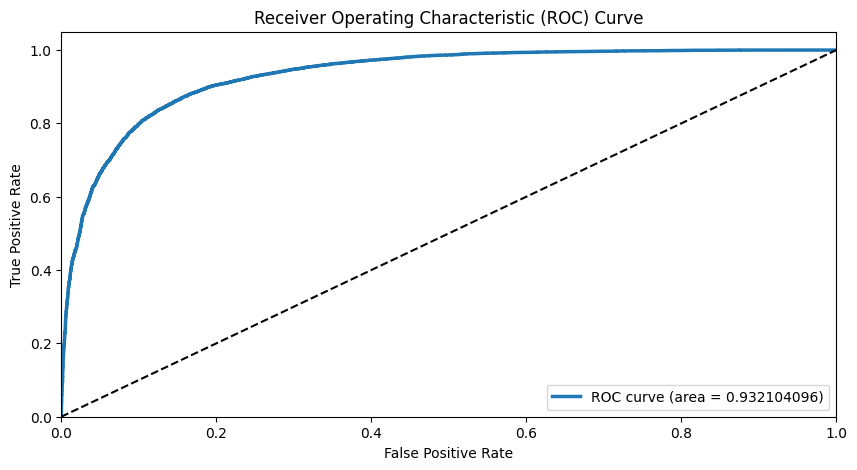

In [97]:
roc_auc  = plot_roc(rf_best, y_test, X_test_vec)

Let's see if your model at least exceeds an ROC-AUC of 0.93

In [98]:
def check_roc(roc_auc):
    if roc_auc > 0.93:
        print('Success!')
    else:
        raise ValueError('Your model is not good enough!')
        
check_roc(roc_auc)

Success!


In [99]:
# Performance evaluation
y_pred_nn = rf_best.predict(X_test_vec)
evaluation.get_performance(y_pred_nn,y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.85648
Precision: 0.8498743718592965
Recall: 0.86592
F1 Score: 0.8578221588207323

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.87      0.86     12500
           0       0.86      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10824   1676
1   1912  10588


(0.85648, 0.8498743718592965, 0.86592, 0.8578221588207323)

---
## 5. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train Word Embedding

I have to train my own word embedding, for this I'm going to use the __gensim__ library.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [100]:
tokenizer = ToktokTokenizer()

In [101]:
token_train=[tokenizer.tokenize(token) for token in X_train.sentence]
    
token_test=[tokenizer.tokenize(token) for token in X_test.sentence]


In [102]:
# Word embedding
model_w2v = Word2Vec(token_train, vector_size=100,epochs=15, window=15, min_count=7, negative= 20, workers=12)

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [103]:
def vectorizer(corpus, model, num_features=100):
    
    # Initiate variables
    vector_sum = np.zeros(shape=(num_features,))
    x_train_average = list()
    corpus_vectors = list()

    # Loop to average the vectors in a sentence
    for sentence in corpus:
        counter = 0
        for token in sentence:
            if token in model.wv:
                word_vector = model.wv[token]           # Get the vector of the word
                vector_sum = vector_sum + word_vector   # Sum vectors of the same sentence
                counter += 1
        average = vector_sum/counter                # Calculate the average of the vectors
        corpus_vectors.append(average)              # Create a list of average vectors
    return corpus_vectors

### *Don't change anything in this block, just make it run correctly*

Let's do a simple check of the embedding that you just trained.

In [104]:
def check_embedding(model):
    vector = model.wv['computer']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

Success! Your embedding tells me that "women" and "man" are similar with a score of 0.7156654596328735


Now, we are going to check the vectorizer, remember that the vectorizer must generate an average vector of all the words present in the same review. So we're going to get two vectors of two words and manually average them, then using those two words we'll simulate a tokenized sentence and see that it matches the manual way.

In [105]:
def check_vectorizer(model):
    vector1 = model.wv['personal']
    vector2 = model.wv['computer']
    avg = vectorizer([['personal', 'computer']], model)[0]

    if np.allclose((vector1 + vector2) / 2, avg):
        print('Success!')
    else:
        raise ValueError('You should check your vectorizer!')
        
check_vectorizer(model_w2v)

Success!


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model I show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [106]:
# Vectorize x_train, x_test
X_train_w2v = vectorizer(token_train, model=model_w2v, num_features=100)
X_test_w2v = vectorizer(token_test, model=model_w2v, num_features=100)

# Creating the classifier
Logisticregression = LogisticRegression(max_iter=2000)   

# Training the model
Logisticregression.fit(X_train_w2v, y_train)

# Predictions
predictions = Logisticregression.predict(X_test_w2v)

In [107]:
# Calculate the performance of Word 2 Vec
get_performance(predictions.round(), y_test)

Model Performance metrics:
------------------------------
Accuracy: 0.69668
Precision: 1.0
Recall: 0.39336
F1 Score: 0.5646207728081759

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       1.00      0.39      0.56     12500
           0       0.62      1.00      0.77     12500

    accuracy                           0.70     25000
   macro avg       0.81      0.70      0.67     25000
weighted avg       0.81      0.70      0.67     25000


Prediction Confusion Matrix:
------------------------------
      0      1
0  4917   7583
1     0  12500


(0.69668, 1.0, 0.39336, 0.5646207728081759)

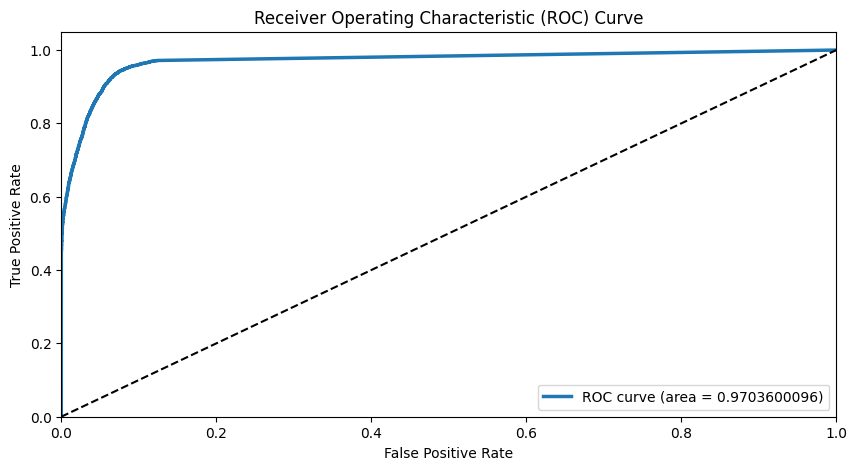

In [108]:
# Calculate the roc_auc of Word 2 Vec
roc_auc = plot_roc(model=Logisticregression, y_test=y_test, features=X_test_w2v)

### *Don't change anything in this block, just make it run correctly*

In [109]:
check_roc(roc_auc)

Success!
